<a href="https://colab.research.google.com/github/barakbeilin/Adversarial-Learning/blob/main/Adversarial_Learning_assignment_II_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt


In [ ]:
from functools import partial

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
#consts 
SEED = 555
IMAGE_SIZE = 28
BATCH = 32
train_kwargs = {'batch_size': BATCH}
test_kwargs = {'batch_size': BATCH}
fgsm_kwargs = {'batch_size': 1}


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
 torch.cuda.is_available()

False

In [ ]:
if use_cuda:
  cuda_kwargs = {'num_workers': 1,
                  'pin_memory': False,
                  'shuffle': True}
  train_kwargs.update(cuda_kwargs)
  test_kwargs.update(cuda_kwargs)
  fgsm_kwargs.update(cuda_kwargs)


In [ ]:
train_kwargs

{'batch_size': 32}

In [ ]:

def get_transform():
  return transforms.Compose([
        transforms.ToTensor(), # transforms image to tensor and moves to into (0,1)
     ])
def get_datasets(requires_download = False,dst='./data',fgsm_dataset_size = 1000):
  transform=get_transform()
  dataset1 = datasets.MNIST(dst, train=True, download=requires_download,
                       transform=transform)
  dataset2 = datasets.MNIST(dst, train=False,transform=transform)
  
 
  dataset_fgsm,dataset_test = torch.utils.data.random_split(dataset2, [fgsm_dataset_size, len(dataset2)-fgsm_dataset_size], generator=torch.Generator().manual_seed(42) )
  
  
  return dataset1, dataset_test, dataset_fgsm

dataset1, dataset_test, dataset_fgsm = get_datasets(requires_download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


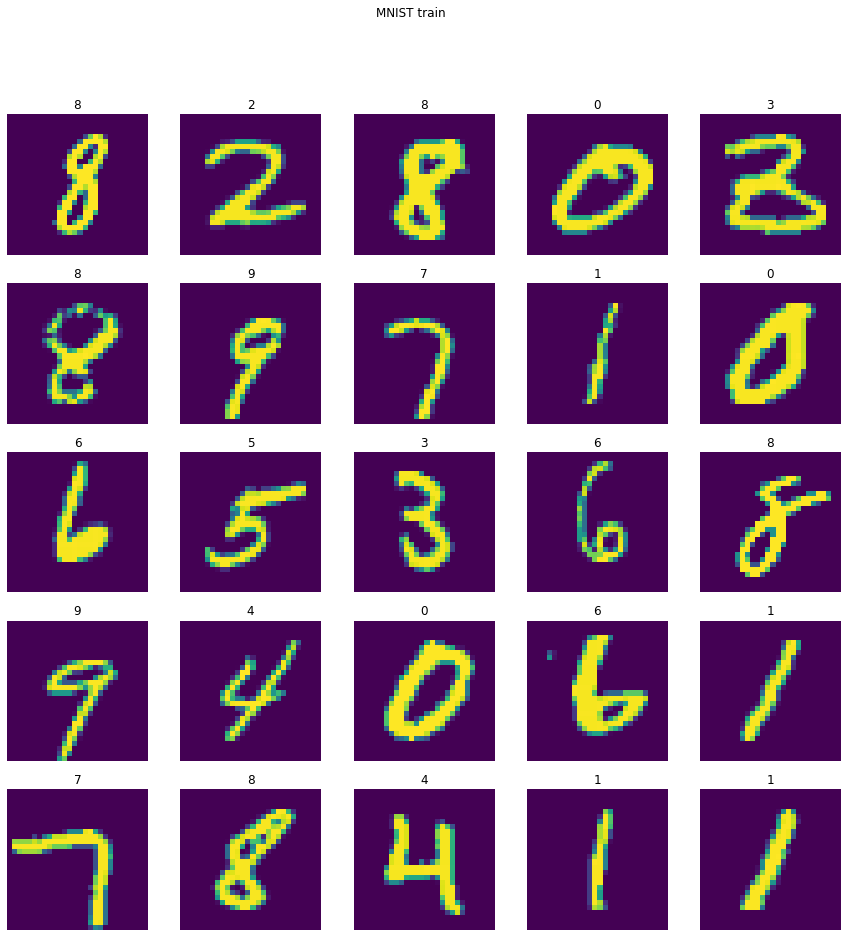

In [ ]:
def print_dataset_sample(is_train,dst='./data'):
  dataset = datasets.MNIST(dst, train=is_train, download=False,
                       transform=get_transform())
  plt.figure(figsize=(15, 15))

  inds = torch.randint(high=len(dataset),size=(25,))

  for i,ind in enumerate(inds):
      plt.subplot(5, 5, i + 1)
      plt.imshow(dataset[ind][0].cpu().reshape(IMAGE_SIZE, IMAGE_SIZE))
      plt.title(dataset[ind][1])
      plt.axis('off')
  dataset_name = 'train' if is_train else 'test'
  plt.suptitle('MNIST ' + dataset_name)
  plt.show()
print_dataset_sample(True)

In [ ]:
class Trainer:
  def __init__(self, model,train_kwargs,test_kwargs,fgsm_kwargs,  epochs=10, learning_scheme='Adam'):
    self.model = model.to(device)
    self.epochs = epochs
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    self.dataset_train, self.dataset_test, self.dataset_fgsm = get_datasets(requires_download=True)
    
    self.train_dataloader = torch.utils.data.DataLoader(self.dataset_train,**train_kwargs)
    self.test_dataloader = torch.utils.data.DataLoader( self.dataset_test, **test_kwargs)
    self.fgsm_input_dataloader = torch.utils.data.DataLoader( self.dataset_fgsm, **fgsm_kwargs)

    
  def train(self):
    for epoch in range(1, self.epochs + 1):
      self._train_single_epoch()
      train_accuracy = self.evaluate_accuracy_on_dataset(
          self.train_dataloader)
      test_accuracy = self.evaluate_accuracy_on_dataset(
          self.test_dataloader)
      print(f"Epoch # {epoch} : Train accuracy: {train_accuracy:.3f}[%],"
            f" Test accuracy: {test_accuracy:.3f}[%]")   


  def _train_single_epoch(self):
      self.model.train()
      for batch in self.train_dataloader:
          inputs, labels = self._get_images_and_labels_to_device(batch)
          self.optimizer.zero_grad()

          outputs = self.model(inputs)
          loss = self.criterion(outputs, labels)
          loss.backward()
          self.optimizer.step()

  def _get_images_and_labels_to_device(self, batch):
  
    inputs, labels = batch[0].to(device), batch[1].to(device)
    return inputs, labels

  def evaluate_accuracy_on_dataset(self, dataloader):
    correct,total = 0,0
      
    self.model.eval()
    with torch.no_grad():
      for batch in dataloader:
        inputs, labels = self._get_images_and_labels_to_device(batch)
        outputs = self.model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [ ]:


class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    try:
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
    except Exception as e:
      import pdb
      pdb.set_trace()
      print(x.shape)
    return x


net = Net()

In [ ]:
net = Net()
fc_trainer = Trainer(net, epochs=1, train_kwargs=train_kwargs,test_kwargs=test_kwargs,fgsm_kwargs=fgsm_kwargs)
fc_trainer.train()

Epoch # 1 : Train accuracy: 96.333[%], Test accuracy: 96.989[%]


In [ ]:
def fgsm_attack(image,target, epsilon, model,device):
  image.requires_grad = True
  model.eval()
  output = model(image)
  # Calculate the loss
  loss = F.cross_entropy(output, target)# F.nll_loss(output, target)
  # Zero all existing gradients
  model.zero_grad()
  # Calculate gradients of model in backward pass
  loss.backward()
  # Collect datagrad
  data_grad = image.grad.data
  # Call FGSM Attack
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad
  # Adding clipping to maintain [0,1] range
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  # Return the perturbed image

  return perturbed_image

def test_attack(data_loader,model,epsilon,device):
  # Accuracy counter
  correct = 0
  adv_examples = []

  # Loop over all examples in test set
  for data, target in data_loader:
    
      # Send the data and label to the device
    data, target = data.to(device), target.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    

    # Forward pass the data through the model
    model.eval()
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    # If the initial prediction is wrong, dont bother attacking, just move on
    if init_pred.item() != target.item():
      continue

    perturbed_data = fgsm_attack(data,target, epsilon, model,device)
    # Re-classify the perturbed image
    output = model(perturbed_data)

    # Check for success
    final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    if final_pred.item() == target.item():
      correct += 1
    else:
      # Save some adv examples for visualization later
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(data_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(data_loader), final_acc))

  # Return the accuracy and an adversarial example
  return final_acc, adv_examples

In [ ]:
fgsm_loader = torch.utils.data.DataLoader( dataset_fgsm, **fgsm_kwargs)

final_acc, adv_examples = test_attack(fgsm_loader, net,0.3, device)

Epsilon: 0.3	Test Accuracy = 39 / 1000 = 0.039


Epsilon: 0.0	Test Accuracy = 986 / 1000 = 0.986
Epsilon: 0.0555555559694767	Test Accuracy = 914 / 1000 = 0.914
Epsilon: 0.1111111119389534	Test Accuracy = 740 / 1000 = 0.74
Epsilon: 0.1666666716337204	Test Accuracy = 477 / 1000 = 0.477
Epsilon: 0.2222222238779068	Test Accuracy = 230 / 1000 = 0.23
Epsilon: 0.2777777910232544	Test Accuracy = 86 / 1000 = 0.086
Epsilon: 0.3333333432674408	Test Accuracy = 23 / 1000 = 0.023
Epsilon: 0.3888888955116272	Test Accuracy = 8 / 1000 = 0.008
Epsilon: 0.4444444477558136	Test Accuracy = 6 / 1000 = 0.006
Epsilon: 0.5	Test Accuracy = 5 / 1000 = 0.005


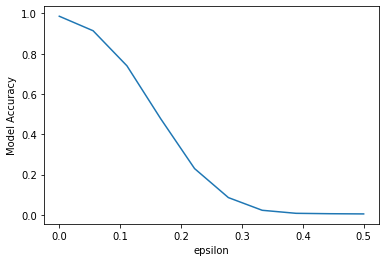

In [ ]:
res  = []
epsilons =torch.linspace(start=0,end=0.5,steps=10)
for epsilon in epsilons:
  final_acc, adv_examples = test_attack(fgsm_loader, net,epsilon, device)
  res.append(final_acc)
plt.plot(epsilons, res)
plt.xlabel('epsilon')
plt.ylabel('Model Accuracy')
plt.show()

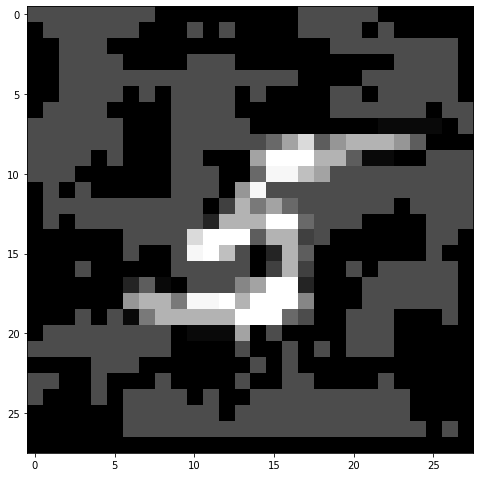

In [ ]:

plt.figure(figsize=(8,10))
orig,adv,ex = adv_examples[0]
plt.imshow(ex, cmap="gray")
plt.show()


In [ ]:
class FGSMDataset(Dataset):
  """FGSM attacked dataset."""
  
  def __init__(self, fgsm_input_dataloader, fgsm_attack):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self._input_dataloader = fgsm_input_dataloader
    self._input_dataloader_iterator = iter(fgsm_input_dataloader)
    self.fgsm_attack = fgsm_attack
    

  def __len__(self):
    return len(self._input_dataloader) # *self._input_dataloader.batch_size

  def __getitem__(self, idx):
 
    image, label = next(self._input_dataloader_iterator)
    return self.fgsm_attack(image=image,target=label)[0], label[0]

In [ ]:
fgsm_guard_trainer = FGSMAttackTrainer(net, epochs=1, train_kwargs=train_kwargs,test_kwargs=test_kwargs,fgsm_kwargs=fgsm_kwargs,device=device)


idl =iter(fgsm_guard_trainer.new_train_dataloader)
a,b = next(idl)
a.shape

torch.Size([1, 1, 28, 28])

In [ ]:
import copy

class FGSMAttackTrainer(Trainer):
  def __init__(self, model,train_kwargs,test_kwargs,fgsm_kwargs, device, epochs=10, learning_scheme='Adam'):
    super().__init__ (model,train_kwargs,test_kwargs,fgsm_kwargs,  epochs, learning_scheme)
    self.fgsm_attack_dataset = FGSMDataset(
        fgsm_input_dataloader = self.fgsm_input_dataloader,
        fgsm_attack = partial(fgsm_attack, epsilon=0.3, model=copy.deepcopy(self.model),device=device))
    self.fgsm_train_combined_dataset = torch.utils.data.ConcatDataset([self.fgsm_attack_dataset,
                                                                       self.dataset_train])

    self.new_train_dataloader = torch.utils.data.DataLoader(
        self.fgsm_train_combined_dataset, **fgsm_kwargs)
    
  def _train_single_epoch(self):
    
    self.model.train()
    for batch in self.new_train_dataloader:
      inputs, labels = self._get_images_and_labels_to_device(batch)
      self.optimizer.zero_grad()

      outputs = self.model(inputs)
      loss = self.criterion(outputs, labels)
      loss.backward()
      self.optimizer.step()

In [ ]:
net = Net()
fc_trainer = Trainer(net, epochs=1, train_kwargs=train_kwargs,test_kwargs=test_kwargs,fgsm_kwargs=fgsm_kwargs)
fc_trainer.train()



Epoch # 1 : Train accuracy: 96.417[%], Test accuracy: 96.533[%]


In [ ]:
test_loader = torch.utils.data.DataLoader( dataset_test, **fgsm_kwargs)


Epsilon: 0.0	Test Accuracy = 8688 / 9000 = 0.9653333333333334
Epsilon: 0.125	Test Accuracy = 5642 / 9000 = 0.6268888888888889
Epsilon: 0.25	Test Accuracy = 970 / 9000 = 0.10777777777777778
Epsilon: 0.375	Test Accuracy = 44 / 9000 = 0.004888888888888889
Epsilon: 0.5	Test Accuracy = 8 / 9000 = 0.0008888888888888889


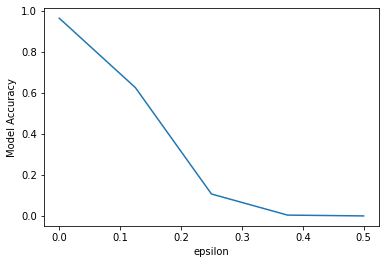

In [ ]:
res  = []
epsilons =torch.linspace(start=0,end=0.5,steps=5)
for epsilon in epsilons:
  final_acc, adv_examples = test_attack(test_loader, net,epsilon, device)
  res.append(final_acc)
plt.plot(epsilons, res)
plt.xlabel('epsilon')
plt.ylabel('Model Accuracy')
plt.show()

In [ ]:
fgsm_guard_trainer = FGSMAttackTrainer(net, epochs=1, train_kwargs=train_kwargs,test_kwargs=test_kwargs,fgsm_kwargs=fgsm_kwargs,device=device)
fgsm_guard_trainer.train()

Epoch # 1 : Train accuracy: 96.932[%], Test accuracy: 97.133[%]


Epsilon: 0.0	Test Accuracy = 8742 / 9000 = 0.9713333333333334
Epsilon: 0.125	Test Accuracy = 5406 / 9000 = 0.6006666666666667
Epsilon: 0.25	Test Accuracy = 2522 / 9000 = 0.2802222222222222
Epsilon: 0.375	Test Accuracy = 1311 / 9000 = 0.14566666666666667
Epsilon: 0.5	Test Accuracy = 878 / 9000 = 0.09755555555555556


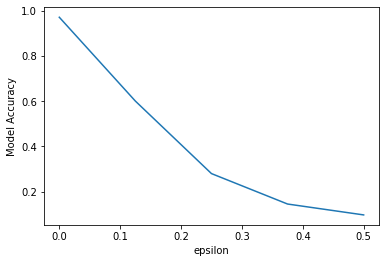

In [ ]:
res  = []
epsilons =torch.linspace(start=0,end=0.5,steps=5)
for epsilon in epsilons:
  final_acc, adv_examples = test_attack(test_loader, net,epsilon, device)
  res.append(final_acc)
plt.plot(epsilons, res)
plt.xlabel('epsilon')
plt.ylabel('Model Accuracy')
plt.show()

In [ ]:
fgsm_guard_trainer = FGSMAttackTrainer(net, epochs=1, train_kwargs=train_kwargs,test_kwargs=test_kwargs,fgsm_kwargs=fgsm_kwargs,device=device)
fgsm_guard_trainer.train()

Epoch # 1 : Train accuracy: 96.737[%], Test accuracy: 96.989[%]


Epsilon: 0.0	Test Accuracy = 8729 / 9000 = 0.9698888888888889
Epsilon: 0.125	Test Accuracy = 3243 / 9000 = 0.36033333333333334
Epsilon: 0.25	Test Accuracy = 1484 / 9000 = 0.1648888888888889
Epsilon: 0.375	Test Accuracy = 1094 / 9000 = 0.12155555555555556
Epsilon: 0.5	Test Accuracy = 963 / 9000 = 0.107


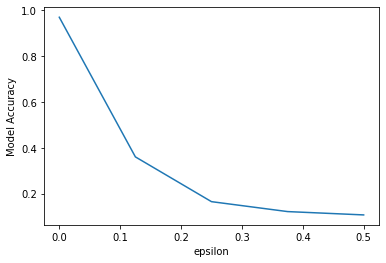

In [ ]:
res  = []
epsilons =torch.linspace(start=0,end=0.5,steps=5)
for epsilon in epsilons:
  final_acc, adv_examples = test_attack(test_loader, net,epsilon, device)
  res.append(final_acc)
plt.plot(epsilons, res)
plt.xlabel('epsilon')
plt.ylabel('Model Accuracy')
plt.show()

In [ ]:
fgsm_guard_trainer = FGSMAttackTrainer(net, epochs=1, train_kwargs=train_kwargs,test_kwargs=test_kwargs,fgsm_kwargs=fgsm_kwargs,device=device)
fgsm_guard_trainer.train()

Epoch # 1 : Train accuracy: 97.248[%], Test accuracy: 97.367[%]


Epsilon: 0.0	Test Accuracy = 8763 / 9000 = 0.9736666666666667
Epsilon: 0.125	Test Accuracy = 3598 / 9000 = 0.3997777777777778
Epsilon: 0.25	Test Accuracy = 1818 / 9000 = 0.202
Epsilon: 0.375	Test Accuracy = 1406 / 9000 = 0.15622222222222223
Epsilon: 0.5	Test Accuracy = 1171 / 9000 = 0.13011111111111112


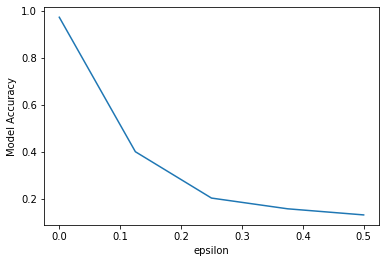

In [ ]:
res  = []
epsilons =torch.linspace(start=0,end=0.5,steps=5)
for epsilon in epsilons:
  final_acc, adv_examples = test_attack(test_loader, net,epsilon, device)
  res.append(final_acc)
plt.plot(epsilons, res)
plt.xlabel('epsilon')
plt.ylabel('Model Accuracy')
plt.show()

In [ ]:
fgsm_guard_trainer = FGSMAttackTrainer(net, epochs=1, train_kwargs=train_kwargs,test_kwargs=test_kwargs,fgsm_kwargs=fgsm_kwargs,device=device)
fgsm_guard_trainer.train()

Epoch # 1 : Train accuracy: 96.660[%], Test accuracy: 96.711[%]


Epsilon: 0.0	Test Accuracy = 8704 / 9000 = 0.9671111111111111
Epsilon: 0.125	Test Accuracy = 5696 / 9000 = 0.6328888888888888
Epsilon: 0.25	Test Accuracy = 3832 / 9000 = 0.42577777777777776
Epsilon: 0.375	Test Accuracy = 2315 / 9000 = 0.25722222222222224
Epsilon: 0.5	Test Accuracy = 1582 / 9000 = 0.17577777777777778


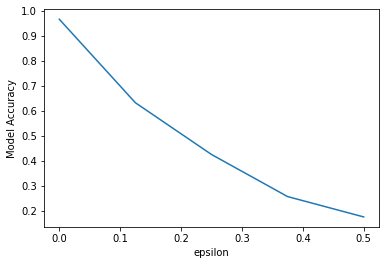

In [ ]:
res  = []
epsilons =torch.linspace(start=0,end=0.5,steps=5)
for epsilon in epsilons:
  final_acc, adv_examples = test_attack(test_loader, net,epsilon, device)
  res.append(final_acc)
plt.plot(epsilons, res)
plt.xlabel('epsilon')
plt.ylabel('Model Accuracy')
plt.show()